In [1]:
%pylab inline

import pandas as pd
import pickle
import matplotlib.dates as md
import statsmodels.api as sm
import scipy.stats as dists

from scipy.misc import factorial
from scipy.optimize import minimize

tableau = pickle.load(open('tableau.colors', 'rb'))

rcParams['figure.figsize'] = (10,8)
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.5
rcParams['axes.prop_cycle'] = cycler('color', tableau)

xfmt = md.DateFormatter('%H:%M:%S')

Populating the interactive namespace from numpy and matplotlib


In [143]:
data = pd.read_csv('../GDAX/data/2016-10-14.trades.csv', index_col=0)
data.t = pd.to_datetime(1e9*data.t)

def consolidate(data):
    columns = ['t', 'px', 'sz', 'sd', 'bid', 'mid', 'ask']
    if data.get('glosten') is not None: columns += ['glosten']
    df = pd.DataFrame(columns=columns)
    df.px = (data.px * data.sz).groupby(data.t).sum() / data.groupby(data.t).sz.sum()
    df.sz = data.groupby(data.t).sz.sum()
    df.sd = list(map(lambda group: group[1].sd.iloc[-1], list(data.groupby(data.t))))
    df.bid = list(map(lambda group: group[1].bid.iloc[-1], list(data.groupby(data.t))))
    df.ask = list(map(lambda group: group[1].ask.iloc[-1], list(data.groupby(data.t))))
    df.mid = 0.5*(df.bid + df.ask)
    if data.get('glosten') is not None: 
        df.glosten = list(map(lambda group: group[1].glosten.iloc[-1], list(data.groupby(data.t))))
    df.t = df.index
    df.index = range(len(df))
    return df
df = consolidate(data)

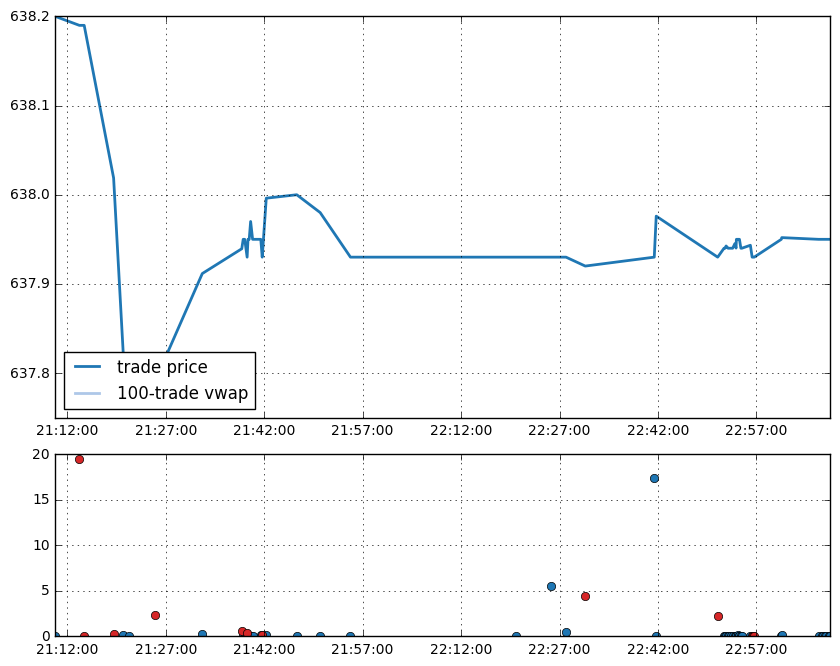

In [144]:
ax = []
ax.append(subplot2grid((3,1),(0,0), rowspan=2))
ax.append(subplot2grid((3,1),(2,0)))

ax[0].plot(df.t, df.px, lw=2, label='trade price')
if data.get('glosten') is not None: 
    ax[0].plot(df.t, df.glosten, lw=2, label='model out')
ax[0].plot(df.t, (df.px * df.sz).rolling(100).sum() / df.sz.rolling(100).sum(), lw=2, label='100-trade vwap')
#ax[1].plot(df.t, (df.sz * (df.sd == 'b')).cumsum(), '-', c=tableau[4])
#ax[1].plot(df.t, (df.sz * (df.sd == 's')).cumsum(), '-', c=tableau[3])
ax[1].plot(df.loc[df.sd == 'b'].t, df.sz.loc[df.sd == 'b'], 'o', c=tableau[0])
ax[1].plot(df.loc[df.sd == 's'].t, df.sz.loc[df.sd == 's'], 'o', c=tableau[6])

ax[0].xaxis.set_major_formatter(xfmt)
ax[0].yaxis.get_major_formatter().set_useOffset(False)
ax[0].legend(loc='lower left')
ax[1].xaxis.set_major_formatter(xfmt)

In [145]:
print('total trades in dataset:   %d' % (len(df)))
print('total volume traded:       %0.2f BTC' % (df.sz.sum()))
print('total dollar value traded: %0.2f USD' % ((df.sz*df.px).sum()))
print('time elapsed over dataset: %0.2f hours' % ((df.t.iloc[-1] - df.t.iloc[0]).total_seconds() / 3600))
print('avg. time between trades:  %0.2f seconds' % ((df.t - df.t.shift(1)).mean().total_seconds()))
print('percent trades bought:     %0.1f%%' % (100.*len(df.loc[df.sd == 'b']) / len(df)))
print('percent volume bought:     %0.1f%%' % (100.*(df.sz * (df.sd == 'b')).sum() / df.sz.sum()))
print('std dev in price change:   %0.1f cents' % (100.*(df.px - df.px.shift(1)).std()))

total trades in dataset:   59
total volume traded:       55.23 BTC
total dollar value traded: 35234.46 USD
time elapsed over dataset: 1.97 hours
avg. time between trades:  122.19 seconds
percent trades bought:     79.7%
percent volume bought:     45.5%
std dev in price change:   4.1 cents


In [146]:
dt = pd.Timedelta(seconds=30.)
px = pd.Series(list(map(lambda c: df.loc[df.t >= df.t.iloc[0] + c*dt].iloc[0].px, range(0,len(df)))))
px.index = list(map(lambda c: df.t.iloc[0] + c*dt, range(0,len(df))))

In [147]:
model = sm.tsa.AR(px).fit(1)
theta = (1 - model.params['L1.y'])/(dt.total_seconds()/3600)
mu = model.params['const']/(1 - model.params['L1.y'])
sigma = px.std()/sqrt(dt.total_seconds()/3600)
print('(theta, mu, sigma) = (%0.4f, %0.4f, %0.4f)' % (theta, mu, sigma))
print('model pvalue = %0.4f' % model.pvalues['L1.y'])

(theta, mu, sigma) = (9.9398, 637.8971, 1.3473)
model pvalue = 0.0000
